# Q-learning

- Init `Q`
- Repeat an episode
  - For each step:
    - get an action from the policy(`Q`, `epsilon`)
    - get a next state and the reward
    - udpate `Q` with Q learning algorithm
    - go to the next state
  - The current episode ends when the goal state is found.

In [1]:
%matplotlib inline
import math
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib import animation
from scipy.special import softmax
import gym

In [2]:
np.random.seed(0)

In [3]:
# force = -1 or 1

# x, x_dot, theta, theta_dot = observation
# -2.4 <= x <= 2.4
# -inf < x_dot < inf
# -12º <= theta <= 12º
# -inf < theta_dot < inf

N_FEATURES = 4
N_INTERVALS_PER_FEATURE = 6
N_PIVOTS = N_INTERVALS_PER_FEATURE - 1
N = N_INTERVALS_PER_FEATURE ** N_FEATURES

def digitize(_min, _max, n_intervals=N_INTERVALS_PER_FEATURE):
    return np.linspace(_min, _max, n_intervals+1)[1:-1]

PIVOTS = [
    digitize(-2.4, 2.4),
    digitize(-3, 3),
    digitize(-0.5, 0.5),
    digitize(-2, 2),
]

def observations2state(observation):
    """digitize observation to a state"""
    feature_indices = [np.sum(PIVOTS[idx] < val) for idx, val in enumerate(observation)]
    
    return np.sum(
        [
            feature_indices[i] * N_INTERVALS_PER_FEATURE**(i)
            for i
            in range(N_FEATURES)
        ]
    )

N_ACTIONS = 2
print(f"N={N}")

def action2force(action):
    return action

N=1296


In [4]:
uniform_q = np.ones((N,N_ACTIONS))
initial_q = np.random.rand(N, N_ACTIONS) * uniform_q

In [5]:
def plot_rewards(scores, epsilons):
    plt.plot(
        tuple(range(len(scores))),
        tuple(h for h in scores)
    )
    plt.draw()
    plt.show()

    plt.plot(
        tuple(range(len(epsilons))),
        tuple(h for h in epsilons)
    )
    plt.draw()
    plt.show()

def get_action(q, state, epsilon):
    if np.random.rand() < epsilon:
        ret = np.random.choice(N_ACTIONS)
    else:
        ret = np.argmax(q[state,:])
    return ret

def run(q, epsilon, env):
    observation = env.reset()
    state = observations2state(observation)

    for i in range(1000):
        action = get_action(q, state, epsilon)

        next_observation, reward, done, info = env.step(action2force(action))
        next_state = observations2state(next_observation)

        q = get_updated_q(state, action, reward, next_state, done, q)
            
        if done:
            return q, i
        else:
            state = next_state
    
    raise Exception("Infinite loop encountered!")

def get_updated_q(state, action, reward, next_state, done, q, eta=0.1, gamma=0.9):
    q_updated = q.copy()
    
    if done:
        q[state, action] = q[state, action] + eta * (reward - q[state, action])
    else:
        q[state, action] = q[state, action] + eta * (reward + gamma*np.max(q[next_state, :]) - q[state, action])

    return q

def train(q, init_epsilon = 0.5, target_epsilon = 0.001, n_iterations = 20000):
    assert target_epsilon <= init_epsilon
    epsilon = init_epsilon

    env = gym.make('CartPole-v1')
    
    all_rewards = []
    all_epsilons = []
    
    avg_window = 50
    avg_rewards = []
    avg_epsilons = []
    
    decay = math.e ** (math.log(target_epsilon/epsilon) / (n_iterations - 1))

    for i in range(n_iterations):
        q, reward = run(q, epsilon, env)
        all_rewards.append(reward)
        all_epsilons.append(epsilon)
        
#         decay = math.e ** (math.log(target_epsilon/epsilon) / ((n_iterations - i)/1))
        epsilon *= decay

        if len(all_rewards) >= avg_window:
            avg_reward = np.average(all_rewards[i-avg_window+1:i+1])
            avg_epsilon = np.average(all_epsilons[i-avg_window+1:i+1])
            
            if avg_reward > 490 and epsilon < 0.05:
                break
            
            avg_rewards.append(avg_reward)
            avg_epsilons.append(avg_epsilon)
            
            if i % 1000 == 0:
                print(i, avg_reward, avg_epsilon)
    
    print(i, avg_reward, avg_epsilon)
    print(f"epsilon={epsilon}")
    print(f"q={q}")
    
    env.close()

    return q, all_rewards, avg_rewards, avg_epsilons

1000 90.04 0.3692542703947553
2000 149.2 0.27062647367074655
3000 172.42 0.19834215640395025
4000 229.2 0.14536497657960504
5000 210.62 0.10653799877497093
6000 209.94 0.07808170475479007
7000 216.22 0.05722608541100659
8000 238.3 0.04194100092655724
9000 198.14 0.03073856172561394
10000 190.0 0.022528293461901803
11000 177.86 0.01651098743122567
12000 179.36 0.012100903533377476
13000 195.18 0.008868752818936477
14000 181.68 0.006499909394901198
15000 192.9 0.0047637839281884
16000 212.08 0.0034913774847796925
17000 297.7 0.002558830737283703
18000 286.76 0.0018753671783161595
19000 206.32 0.0013744567009691894
19999 283.86 0.0010076524617527016
epsilon=0.0009996893023352328
q=[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 ...
 [0.32290711 0.34574585]
 [0.40051046 0.41091573]
 [0.10325322 0.51909894]]


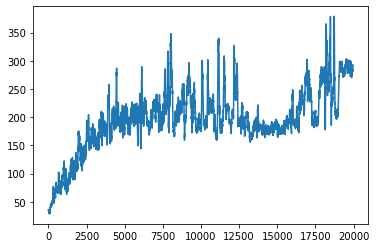

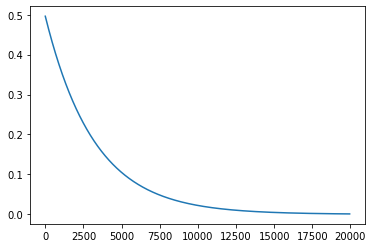

In [6]:
q, all_rewards, avg_rewards, avg_epsilons = train(initial_q)
plot_rewards(avg_rewards, avg_epsilons)

In [18]:
def test(q):
    env = gym.make('CartPole-v1')
    env._max_episode_steps = 1000
    observation = env.reset()
    state = observations2state(observation)

    for i in range(1000):
        env.render()
        action = get_action(q, state, 0)
        observation, reward, done, info = env.step(action2force(action)) # take a random action
        if done:
            print(i)
            break
        else:
            state = observations2state(observation)
    env.close()
    
test(q)

317


In [8]:
# q, all_rewards, avg_rewards, avg_epsilons = train(q, init_epsilon=0.001, target_epsilon=0.001, n_iterations=5000)
# plot_rewards(avg_rewards, avg_epsilons)
# test(q)